In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../datasets/alldata_1_for_kaggle.csv', encoding="latin-1")
df.head(3)

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...


In [2]:
df = df.drop('Unnamed: 0', axis = 1)
df = df.rename({'0': 'target', 'a': 'feature'}, axis = 1)
df.head(3)

,target,feature
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...


In [3]:
df.shape

(7570, 2)

In [4]:
df.isnull().sum()

target     0
feature    0
dtype: int64

In [5]:
df.isna().sum()

target     0
feature    0
dtype: int64

In [6]:
df['target'].value_counts()

target
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64

In [7]:
"""
Now we do Data Preprocessing.
"""
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

regexp = RegexpTokenizer("[\w']+")

def convert_to_lowercase(text):
    return text.lower()
def remove_whitespace(text):
    return text.strip()
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha


In [8]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = discard_non_alpha(text)
    return text

In [9]:
df['feature'] = df['feature'].apply(text_normalizer)

In [10]:
df['feature'][0]

'thyroid surgery children single institution osama ibrahim almosallama ali aseerib ahmed alhumaida ali alzahranic saif alsobhib saud alshanafeybfrom adepartment surgery college medicine qassim university buraidah al qassim saudi arabia bdepartment surgery king faisal specialist hospital research center riyadh saudi arabia cdepartment medicine king faisal specialist hospital research center riyadh saudi arabia correspondence dr osama ibrahim almosallam department surgery college medicine qassim university po box buraidah al qassim saudi arabia osamaiaahotmailcom orcid citation almosallam oi aseeri alhumaid alzahrani alsobhi alshanafey thyroid surgery children single institution ann saudi med received january accepted may published august copyright copyright annals saudi medicine saudi arabia access creative commons attributionnoncommercialnoderivatives international license cc byncnd details accessed httpcreativecommons nonebackground data thyroid surgery children scarceobjective analyz

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_features=15000, smooth_idf=True, sublinear_tf=True)
vectorizer.fit(df['feature'])
df_features = vectorizer.transform(df['feature'])
df_target = df['target']

df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features.toarray(), df_target, test_size = 0.2, random_state=42)

In [12]:
"""from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(df_features_train, df_target_train)
target_prediction = nb_model.predict(df_features_test)"""

'from sklearn.naive_bayes import GaussianNB\n\nnb_model = GaussianNB()\nnb_model.fit(df_features_train, df_target_train)\ntarget_prediction = nb_model.predict(df_features_test)'

In [13]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(df_features_train, df_target_train)
target_prediction = nb_model.predict(df_features_test)

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#gaussian 95% acc.

print(f"classification report: \n{classification_report(df_target_test, target_prediction)}")

classification report: 
                precision    recall  f1-score   support

  Colon_Cancer       0.78      0.84      0.81       517
   Lung_Cancer       0.95      0.99      0.97       407
Thyroid_Cancer       0.85      0.77      0.81       590

      accuracy                           0.85      1514
     macro avg       0.86      0.87      0.86      1514
  weighted avg       0.85      0.85      0.85      1514



In [15]:
accuracy_score(df_target_test, target_prediction)

0.8533685601056803

array([[433,  10,  74],
       [  1, 402,   4],
       [123,  10, 457]])

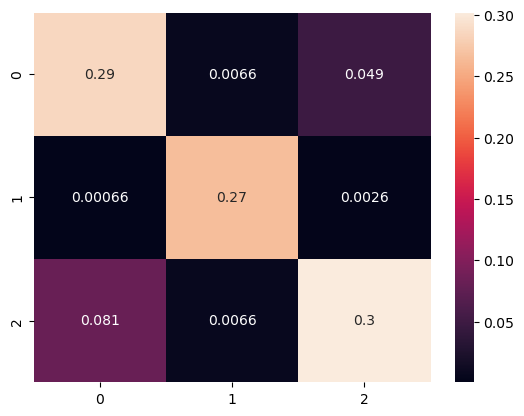

In [16]:
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(df_target_test, target_prediction)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True)
cf_matrix